[@LorenaABarba](https://twitter.com/LorenaABarba)

12 steps to Navier-Stokes
=====
***

We continue our journey to solve the Navier-Stokes equation with Step 4. But don't continue unless you have completed the previous steps! In fact, this next step will be a combination of the two previous ones. The wonders of *code reuse*!

Step 4: Burgers' Equation
----
***

You can read about Burgers' Equation on its [wikipedia page](http://en.wikipedia.org/wiki/Burgers'_equation).

Burgers' equation in one spatial dimension looks like this:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}$$

As you can see, it is a combination of non-linear convection and diffusion. It is surprising how much you learn from this neat little equation! 

We can discretize it using the methods we've already detailed in Steps [1](./01_Step_1.ipynb) to [3](./04_Step_3.ipynb).  Using forward difference for time, backward difference for space and our 2nd-order method for the second derivatives yields:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

As before, once we have an initial condition, the only unknown is $u_i^{n+1}$. We will step in time as follows:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

### Initial and Boundary Conditions

To examine some interesting properties of Burgers' equation, it is helpful to use different initial and boundary conditions than we've been using for previous steps.  

Our initial condition for this problem is going to be:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

This has an analytical solution, given by:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

Our boundary condition will be:

$$u(0) = u(2\pi)$$

This is called a *periodic* boundary condition. Pay attention! This will cause you a bit of headache if you don't tread carefully.

### Saving Time with SymPy


The initial condition we're using for Burgers' Equation can be a bit of a pain to evaluate by hand.  The derivative $\frac{\partial \phi}{\partial x}$ isn't too terribly difficult, but it would be easy to drop a sign or forget a factor of $x$ somewhere, so we're going to use SymPy to help us out.  

[SymPy](http://sympy.org/en/) is the symbolic math library for Python.  It has a lot of the same symbolic math functionality as Mathematica with the added benefit that we can easily translate its results back into our Python calculations (it is also free and open source). 

Start by loading the SymPy library, together with our favorite library, NumPy.

In [1]:
import numpy
import sympy

We're also going to tell SymPy that we want all of its output to be rendered using $\LaTeX$. This will make our Notebook beautiful!

In [2]:
from sympy import init_printing
init_printing(use_latex=True)

Start by setting up symbolic variables for the three variables in our initial condition and then type out the full equation for $\phi$.  We should get a nicely rendered version of our $\phi$ equation.

In [3]:
x, nu, t = sympy.symbols('x nu t')
phi = (sympy.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sympy.exp(-(x - 4 * t - 2 * numpy.pi)**2 / (4 * nu * (t + 1))))
phi

It's maybe a little small, but that looks right.  Now to evaluate our partial derivative $\frac{\partial \phi}{\partial x}$ is a trivial task.  

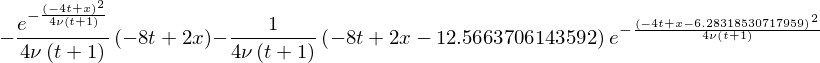

In [4]:
phiprime = phi.diff(x)
phiprime

If you want to see the unrendered version, just use the Python print command.

In [5]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


### Now what?


Now that we have the Pythonic version of our derivative, we can finish writing out the full initial condition equation and then translate it into a usable Python expression.  For this, we'll use the *lambdify* function, which takes a SymPy symbolic equation and turns it into a callable function.  

In [6]:
from sympy.utilities.lambdify import lambdify

u = -2 * nu * (phiprime / phi) + 4
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


### Lambdify

To lambdify this expression into a useable function, we tell lambdify which variables to request and the function we want to plug them in to.

In [7]:
ufunc = lambdify((t, x, nu), u)
print(ufunc(1, 4, 3))

3.4917066420644494


### Back to Burgers' Equation

Now that we have the initial conditions set up, we can proceed and finish setting up the problem.  We can generate the plot of the initial condition using our lambdify-ed function.

In [14]:
from matplotlib import pyplot
%matplotlib inline

###variable declarations
nx = 101
nt = 100
dx = 2 * numpy.pi / (nx - 1)
nu = .07
dt = dx * nu

x = numpy.linspace(0, 2 * numpy.pi, nx)
un = numpy.empty(nx)
t = 0

u = numpy.asarray([ufunc(t, x0, nu) for x0 in x])
u

array([ 4.        ,  4.06283185,  4.12566371,  4.18849556,  4.25132741,
        4.31415927,  4.37699112,  4.43982297,  4.50265482,  4.56548668,
        4.62831853,  4.69115038,  4.75398224,  4.81681409,  4.87964594,
        4.9424778 ,  5.00530965,  5.0681415 ,  5.13097336,  5.19380521,
        5.25663706,  5.31946891,  5.38230077,  5.44513262,  5.50796447,
        5.57079633,  5.63362818,  5.69646003,  5.75929189,  5.82212374,
        5.88495559,  5.94778745,  6.0106193 ,  6.07345115,  6.136283  ,
        6.19911486,  6.26194671,  6.32477856,  6.38761042,  6.45044227,
        6.51327412,  6.57610598,  6.63893783,  6.70176967,  6.76460125,
        6.82742866,  6.89018589,  6.95176632,  6.99367964,  6.72527549,
        4.        ,  1.27472451,  1.00632036,  1.04823368,  1.10981411,
        1.17257134,  1.23539875,  1.29823033,  1.36106217,  1.42389402,
        1.48672588,  1.54955773,  1.61238958,  1.67522144,  1.73805329,
        1.80088514,  1.863717  ,  1.92654885,  1.9893807 ,  2.05

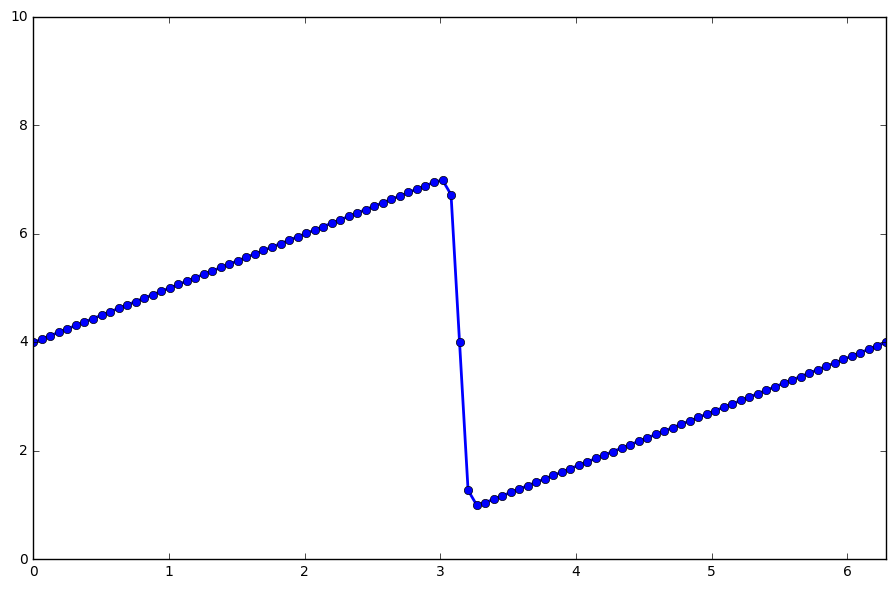

In [15]:
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.plot(x, u, marker='o', lw=2)
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10]);

This is definitely not the hat function we've been dealing with until now. We call it a "saw-tooth function".  Let's proceed forward and see what happens.  

### Periodic Boundary Conditions

One of the big differences between Step 4 and the previous lessons is the use of *periodic* boundary conditions.  If you experiment with Steps 1 and 2 and make the simulation run longer (by increasing `nt`) you will notice that the wave will keep moving to the right until it no longer even shows up in the plot.  

With periodic boundary conditions, when a point gets to the right-hand side of the frame, it *wraps around* back to the front of the frame.  

Recall the discretization that we worked out at the beginning of this notebook:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

What does $u_{i+1}^n$ *mean* when $i$ is already at the end of the frame?

Think about this for a minute before proceeding.  



In [16]:
for n in range(nt):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                (un[i+1] - 2 * un[i] + un[i-1])
    u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                (un[1] - 2 * un[0] + un[-2])
    u[-1] = u[0]
        
u_analytical = numpy.asarray([ufunc(nt * dt, xi, nu) for xi in x])

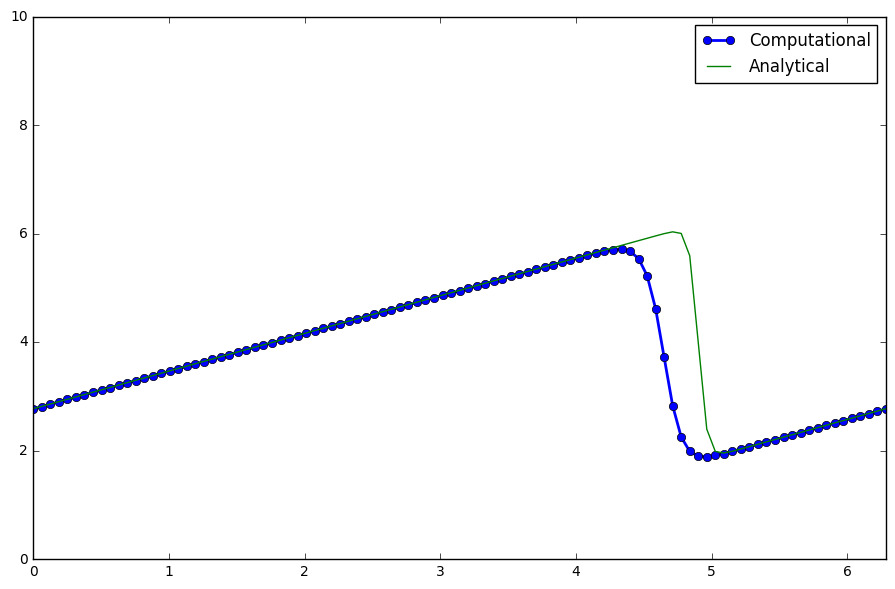

In [17]:
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.plot(x,u, marker='o', lw=2, label='Computational')
pyplot.plot(x, u_analytical, label='Analytical')
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend();

***

What next?
----

The subsequent steps, from 5 to 12, will be in two dimensions. But it is easy to extend the 1D finite-difference formulas to the partial derivatives in 2D or 3D. Just apply the definition — a partial derivative with respect to $x$ is the variation in the $x$ direction *while keeping $y$ constant*.

Before moving on to [Step 5](./07_Step_5.ipynb), make sure you have completed your own code for steps 1 through 4 and you have experimented with the parameters and thought about what is happening. Also, we recommend that you take a slight break to learn about [array operations with NumPy](./06_Array_Operations_with_NumPy.ipynb).

In [12]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()